In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
sss=pd.read_csv("sss.csv")  
sss["Date"]=sss["Date"].astype('datetime64[ns]') # Convert column to date format
sss.columns=["date","sss_price"]
sss.head()

,date,sss_price
0,2012-05-01,1405.82
1,2012-06-01,1278.04
2,2012-08-01,1375.32
3,2012-10-01,1444.49
4,2012-11-01,1427.59


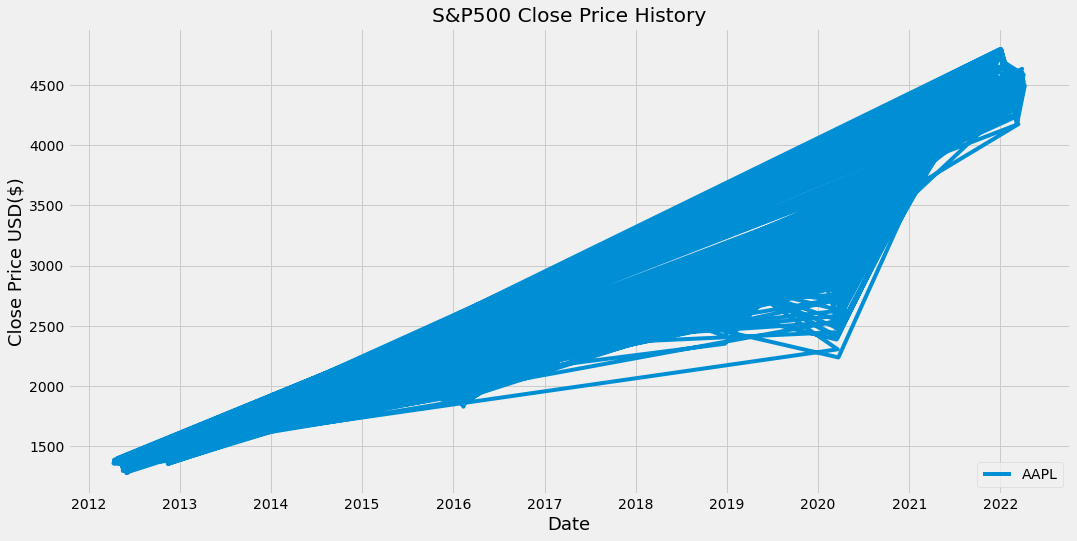

In [7]:
plt.figure(figsize=(16,8))
plt.title('S&P500 Close Price History')
plt.plot(sss[['date','sss_price']].set_index('date'))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.legend(['AAPL'], loc='lower right')

In [8]:
# Loop to read all share price files and transform data
shares=["BrentOilPrices","BP"]


all_data=pd.DataFrame() # here we will store all the data from all shares and oil price in a master dataframe
for index in range(len(shares)):
    stock=pd.DataFrame()

# 1.- Read files
    stock=pd.read_csv(shares[index]+".csv")     
    stock.columns=["Date","Close"]
# 2.- Transform data
    stock=stock[["Date","Close"]]       
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["date","share_price"]
    test=pd.DataFrame(sss) # VLOOKUP equivalent in Python to merge 2 sets of data
    output=stock.merge(test,on="date",how="left")
    stock["sss_price"]=output["sss_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['sss_price']=pd.to_numeric(stock['sss_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["date"]).dt.year # Create a column with the year to filter later
    stock["name"]=shares[index]
    stock = stock.dropna() # get rid of all the NAN rows.
# 3.- Feature Engineering. Create new column with scaled share price from 0 to 1.
#     This will help us comparing companies later on.
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
# 4.- Append data to a master dataframe
    all_data=all_data.append(stock) #append data to one matrix
    
all_data.head(-5)

,date,share_price,sss_price,year,name,share_price_scaled
6316,2012-04-10,121.890000,1358.59,2012,BrentOilPrices,1.000000
6317,2012-04-11,120.410000,1368.71,2012,BrentOilPrices,0.986876
6318,2012-04-12,120.570000,1387.57,2012,BrentOilPrices,0.988295
6319,2012-04-13,120.620000,1370.26,2012,BrentOilPrices,0.988738
6320,2012-04-16,118.230000,1369.57,2012,BrentOilPrices,0.967545
...,...,...,...,...,...,...
8478,2021-01-08,24.400000,3824.68,2021,BP,0.246881
8479,2021-01-11,24.379999,3799.61,2021,BP,0.246362
8480,2021-01-12,25.010000,3801.19,2021,BP,0.262734
8481,2021-01-13,24.780001,3809.84,2021,BP,0.256757


In [9]:
import matplotlib.pyplot as plt

NameError: ignored

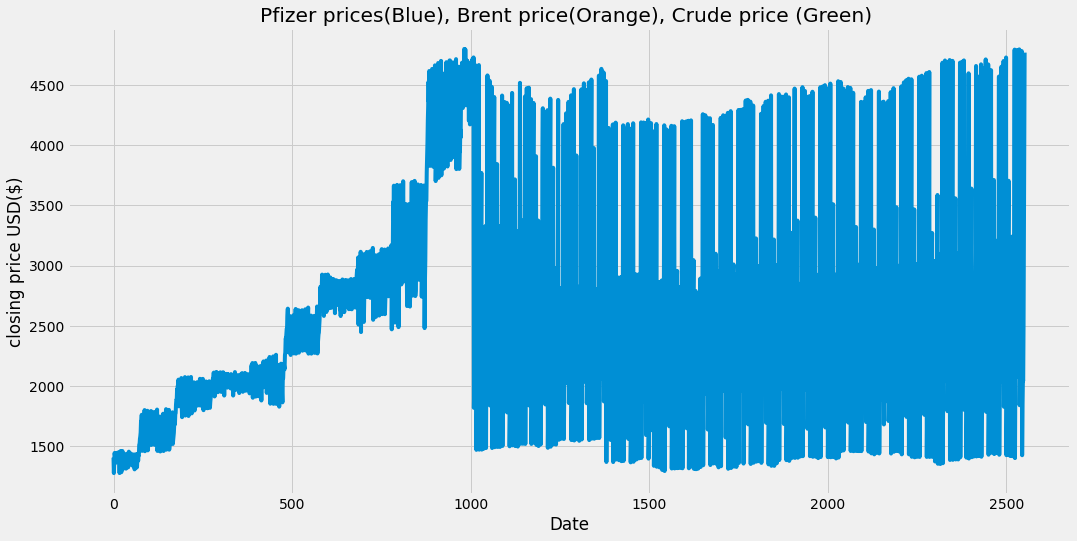

In [12]:
#visualise the close price data
plt.figure(figsize=(16,8))
plt.title('Pfizer prices(Blue), Brent price(Orange), Crude price (Green) ')
plt.xlabel('Date')
plt.ylabel('closing price USD($)')
plt.plot(sss['sss_price'])
plt.plot(df['Price'])
plt.plot(df['crude price'])
plt.show()

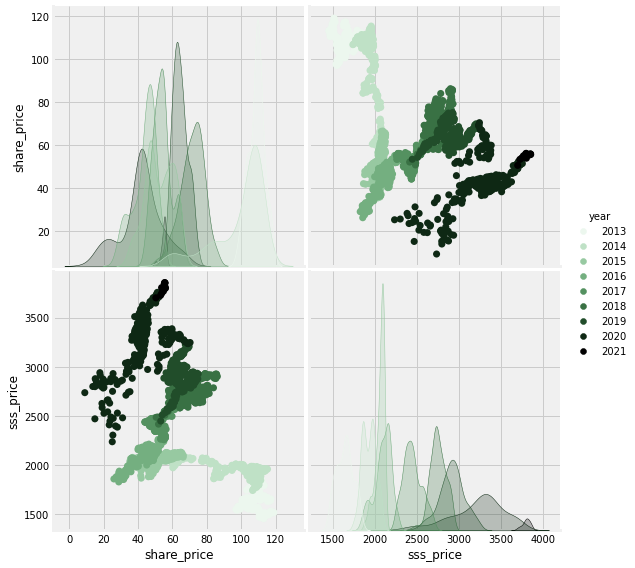

In [ ]:
#==============================================================================
# Pairplot using last 20 years data with filtering on BrentOil share price
#==============================================================================
all_data12=all_data[all_data["year"]>2012]
palette=sns.cubehelix_palette(9, start=2, rot=0, dark=0, light=.95, reverse=False)

ccc = all_data12[all_data12['name']=="BrentOilPrices"].drop(["share_price_scaled"],axis=1)
ccc.head(-5)

sns.pairplot(all_data12[all_data12['name']=="BrentOilPrices"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))


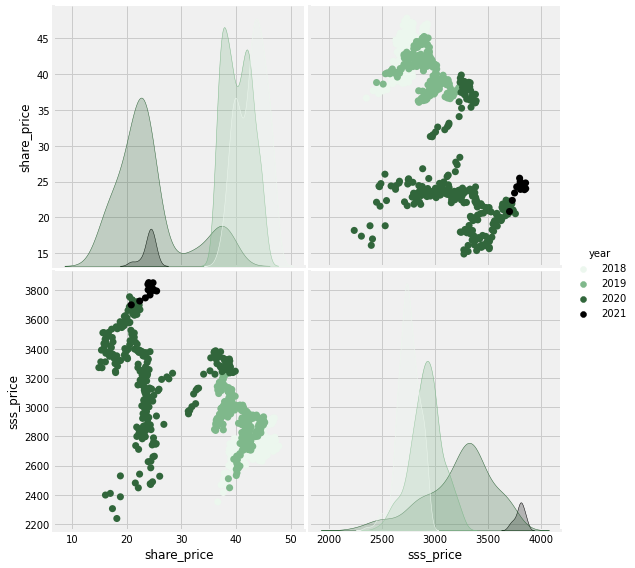

In [ ]:
#==============================================================================
# Pairplot on less data (last 5 years) using BP stock price
#==============================================================================

# to change the size of dataset increase or decrease the year and next line palette year count
all_data13=all_data[all_data["year"]>2017]
palette=sns.cubehelix_palette(4, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data13[all_data13['name']=="BP"].drop(["share_price_scaled"],axis=1),
             hue="year",palette=palette,size=4,markers="o",
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))
#all_data13.head()

In [ ]:

from sklearn import linear_model

# 1.- Data preparation
brentoil=pd.DataFrame()
brentoil=all_data13[(all_data13['name']=="BrentOilPrices") & (all_data13['year']>2019 )] # Extract data from years 2020/21 (2 years data)
brentoil=brentoil[["share_price","sss_price"]].reset_index()

# Just using 1 variable for linear regression. To try with more variables use randomforest
# Split the data into training/testing sets
train = brentoil[:-100]
test = brentoil[-100:]

x_train=train["share_price"].to_frame() #converts the pandas Series to numpy.ndarray
y_train=train["sss_price"].to_frame()
x_test=test["share_price"].to_frame() #converts the pandas Series to numpy.ndarray
y_test=test["sss_price"].to_frame()

# 2.- Create linear regression object
regr = linear_model.LinearRegression()

# 3.- Train the model using the training sets
regr.fit(x_train,y_train)

# The coefficients
print("Coefficients: ",  float(regr.coef_))
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_train) - y_train) ** 2))

Coefficients:  14.888687717554124
Mean squared error: 32625.85


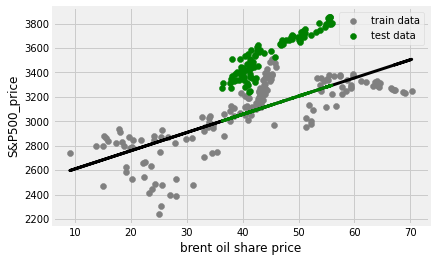

In [ ]:
# Plot outputs using matplotlib
plt_train=plt.scatter(x_train, y_train,  color='grey')
plt_test=plt.scatter(x_test, y_test,  color='green')
plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
plt.plot(x_test,regr.predict(x_test),  color='green', linewidth=3)
plt.xlabel("brent oil share price")
plt.ylabel("S&P500_price")
plt.legend((plt_train, plt_test),("train data", "test data"))
plt.show()

In [ ]:
# Load share price of other variables


from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
sss_df=pd.DataFrame()
sss_df=all_data13[(all_data13['year']>2015 )]
sss_df=sss_df[["date", "sss_price"]].reset_index()

sss_df = sss_df[-400:].reset_index() # adjust this between 1500 and 150 to limit or increase data

#all_data13.head(-5)

# Load share price of other variables
# aapl_df['BrentOilPrices']=all_data13[(all_data13['name']=="BrentOilPrices")][-373:].reset_index()['share_price']
#aapl_df['BP']=all_data13[(all_data13['name']=="BP")][-373:].reset_index()['share_price']

sss_df['BrentOilPrices']=all_data13[(all_data13['name']=="BrentOilPrices")].reset_index()['share_price']
sss_df['BP']=all_data13[(all_data13['name']=="BP")].reset_index()['share_price']

# aapl_df.dropna(3)
sss_df.head(-1)
train = sss_df[:-100]
test = sss_df[-100:]
# train.head(-1)

# aapl_df.head(-1)
x_train=train[["BrentOilPrices","BP"]]
y_train=train['sss_price']

x_test=test[["BrentOilPrices","BP"]] 
y_test=test['sss_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor.fit(x_train, y_train)

# 4.- Predict!
y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)

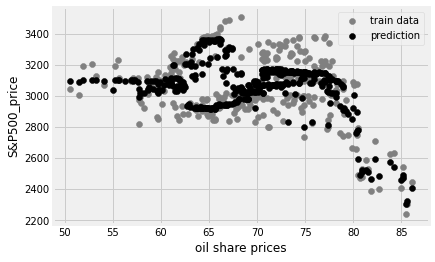

In [ ]:
# We are going to have a look at how fitted data looks like:

x_train.head()
plt_train=plt.scatter(x_train["BrentOilPrices"],y_train,   color='grey')
plt_pred=plt.scatter(sss_df["BrentOilPrices"], regressor.predict(sss_df[["BrentOilPrices","BP"]]),  color='black')

plt.xlabel("oil share prices")
plt.ylabel("S&P500_price")
plt.legend((plt_train,plt_pred),("train data","prediction"))
plt.show()


# This model predicts training data 
# There are many parameters to tune, but a key one is max depth. This will provide the depth of the trees.

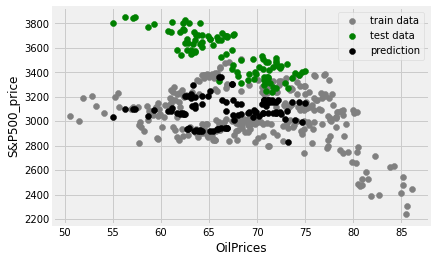

In [ ]:
# predict test data now
plt_train=plt.scatter(x_train["BrentOilPrices"],y_train,   color='grey')
plt_test=plt.scatter(x_test["BrentOilPrices"],y_test,   color='green')
plt_pred=plt.scatter(x_test["BrentOilPrices"], y_pred,  color='black')

plt.xlabel("OilPrices")
plt.ylabel("S&P500_price")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

In [ ]:
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

Mean squared error: 12502.96


Feature ranking:
Feature BrentOilPrices (0.805425)
Feature BP (0.194575)


Text(0, 0.5, 'Importance')

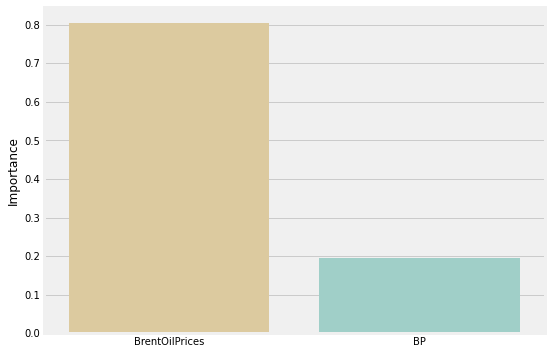

In [ ]:
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

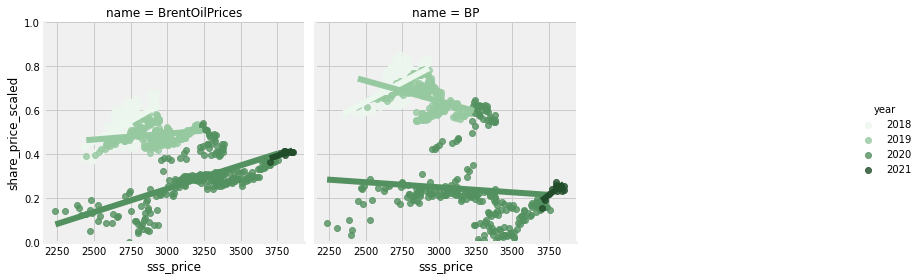

In [ ]:
#We dont really see that much on that chart. Lets add different colors for each year and see if correlations are telling us anything.

palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="sss_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data13, order=1,palette=palette,size=4).set(ylim=(0, 1))

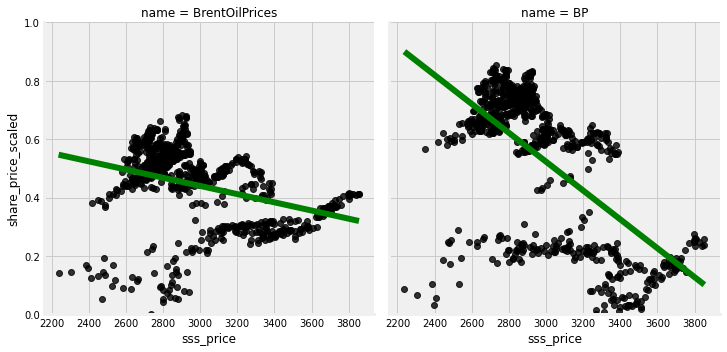

In [ ]:
#Plot of oil price vs share price of different companies using different templates
#The next analysis will do a grid of charts for all companies to check if we see any patterns.
#==============================================================================
# lmplot using using 5 years for all companies
#==============================================================================

sns.lmplot(x="sss_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data13, order=1,line_kws={'color': 'green'},scatter_kws={'color': 'black'}).set(ylim=(0, 1))